Import Libraries

In [94]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import matplotlib.pyplot as plt  

Load and prepare dataset

In [95]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [96]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

In [97]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [98]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

Simple model

In [99]:
model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                464       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [103]:
def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000),
  ]

In [106]:
def compile_and_fit(model, max_epochs=10000):
  model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(),
    verbose=0)
  return history

In [107]:
m1_history = compile_and_fit(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                464       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6840,  binary_crossentropy:0.5728,  loss:0.5728,  val_accuracy:0.6620,  val_binary_crossentropy:0.5853,  val_loss:0.5853,  
....................................................................................................
Epoch: 100, accuracy:0.6820,  binary_crossentropy:0.5697,  loss:0.5697,  val_accuracy:0.6720,  val_binary_crossentropy:0.5828,  val_loss:0.5828,  
..........................................................

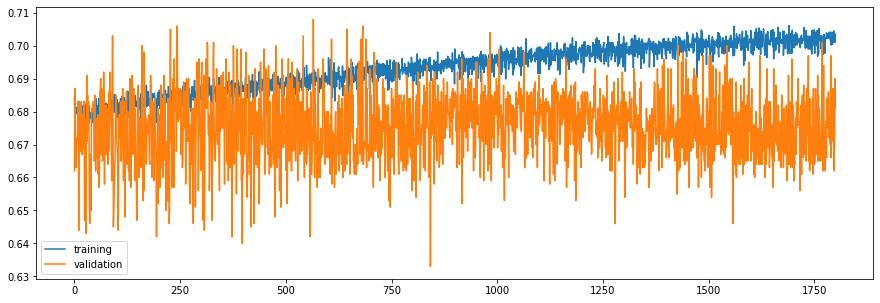

In [138]:
plt.figure(figsize=(15, 5))

plt.plot(m1_history.history['accuracy'][0:])
plt.plot(m1_history.history['val_accuracy'][0:])
plt.legend(['training', 'validation'])
plt.show()

In [109]:
model2 = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(128, activation='elu'),
    layers.Dense(256, activation='elu'),
    layers.Dense(1)
])

m2_history = compile_and_fit(model2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                464       
                                                                 
 dense_9 (Dense)             (None, 64)                1088      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 256)               33024     
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 43,153
Trainable params: 43,153
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5084,  binary_crossentropy:0

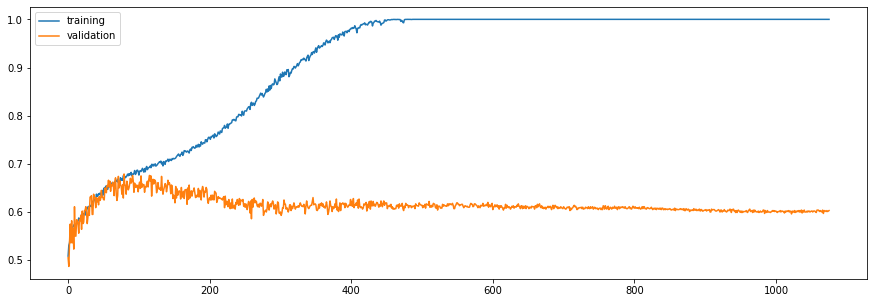

In [137]:
plt.figure(figsize=(15, 5))

plt.plot(m2_history.history['accuracy'][0:])
plt.plot(m2_history.history['val_accuracy'][0:])
plt.legend(['training', 'validation'])
plt.show()

In [111]:
model3 = tf.keras.Sequential([
    layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(128, activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(256, activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

m3_history = compile_and_fit(model3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                464       
                                                                 
 dense_14 (Dense)            (None, 64)                1088      
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 43,153
Trainable params: 43,153
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4829,  binary_crossentropy:0

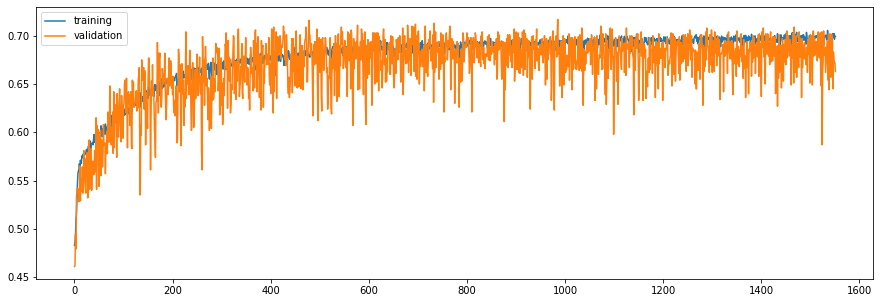

In [136]:
plt.figure(figsize=(15, 5))

plt.plot(m3_history.history['accuracy'][0:])
plt.plot(m3_history.history['val_accuracy'][0:])
plt.legend(['training', 'validation'])
plt.show()

In [115]:
model5 = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

m5_history = compile_and_fit(model5)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 16)                464       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                1088      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 256)              

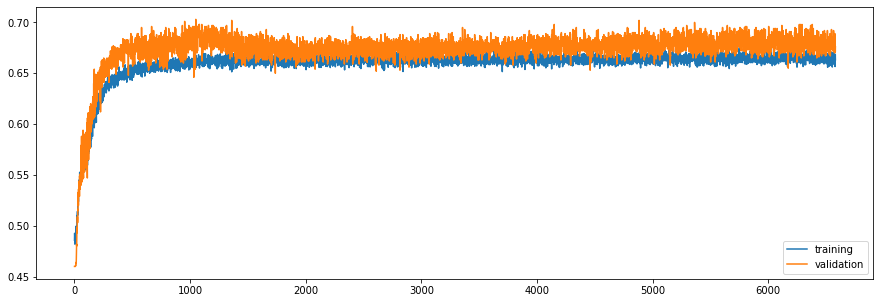

In [134]:
plt.figure(figsize=(15, 5))

plt.plot(m5_history.history['accuracy'][0:])
plt.plot(m5_history.history['val_accuracy'][0:])
plt.legend(['training', 'validation'])
plt.show()

In [113]:
model4 = tf.keras.Sequential([
    layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

m4_history = compile_and_fit(model4)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                464       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 256)              

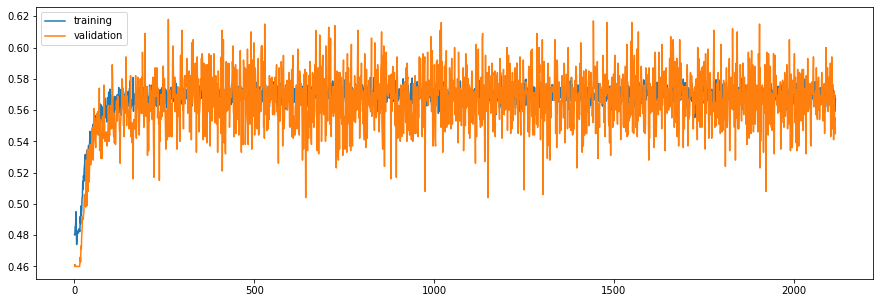

In [135]:
plt.figure(figsize=(15, 5))

plt.plot(m4_history.history['accuracy'][0:])
plt.plot(m4_history.history['val_accuracy'][0:])
plt.legend(['training', 'validation'])
plt.show()